# Compute and plot overall and per-class performance

In [20]:
import os
import pandas as pd
from sklearn.metrics import classification_report, f1_score, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def load_predictions(prediction_dir):
    predictions = {}
    for file_name in os.listdir(prediction_dir):
        if file_name.endswith('.csv'):
            model_name = os.path.splitext(file_name)[0]
            file_path = os.path.join(prediction_dir, file_name)
            df = pd.read_csv(file_path)
            predictions[model_name] = df
    return predictions

def calculate_metrics(predictions):
    metrics = {}
    for model_name, df in predictions.items():
        true_labels = df['true_label']
        predicted_labels = df['prediction']
        
        f1_micro = round(f1_score(true_labels, predicted_labels, average='micro'), 6)
        f1_macro = round(f1_score(true_labels, predicted_labels, average='macro'), 6)
        f1_weighted = round(f1_score(true_labels, predicted_labels, average='weighted'),6)
        accuracy = round(accuracy_score(true_labels, predicted_labels), 6)
        recall = round(recall_score(true_labels, predicted_labels, average='weighted'), 6)
        precision = round(precision_score(true_labels, predicted_labels, average='weighted'), 6)   
        metrics[model_name] = {
                                'f1_micro': f1_micro, 
                                'f1_macro': f1_macro, 
                                'f1_weighted': f1_weighted,
                                'accuracy': accuracy,
                                'recall': recall, 
                                'precision': precision
                                }

    return metrics


def plot_metrics(metrics, classification_type):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    va_position = 'top'

    # Plot F1 weighted
    f1_weighted_bars = axes[0, 0].bar(metrics.keys(), [metric['f1_weighted'] for metric in metrics.values()], color='plum')
    axes[0, 0].set_xlabel('Model')
    axes[0, 0].set_ylabel('F1-score')
    axes[0, 0].set_title(f'F1-score')
    axes[0, 0].tick_params(axis='x', rotation=90)
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0, 0].set_ylim(0, 1)
    for bar in f1_weighted_bars:
        yval = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va=va_position)

    # Plot accuracy
    accuracy_bars = axes[0, 1].bar(metrics.keys(), [metric['accuracy'] for metric in metrics.values()], color='darkseagreen')
    axes[0, 1].set_xlabel('Model')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title(f'Accuracy')
    axes[0, 1].tick_params(axis='x', rotation=90)
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0, 1].set_ylim(0, 1)
    for bar in accuracy_bars:
        yval = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va=va_position)

    # Plot recall
    recall_bars = axes[1, 0].bar(metrics.keys(), [metric['recall'] for metric in metrics.values()], color='skyblue')
    axes[1, 0].set_xlabel('Model')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_title(f'Recall')
    axes[1, 0].tick_params(axis='x', rotation=90)
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1, 0].set_ylim(0, 1)
    for bar in accuracy_bars:
        yval = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va=va_position)

    # Plot precision
    precision_bars = axes[1, 1].bar(metrics.keys(), [metric['precision'] for metric in metrics.values()], color='salmon')
    axes[1, 1].set_xlabel('Model')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title(f'Precision')
    axes[1, 1].tick_params(axis='x', rotation=90)
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1, 1].set_ylim(0, 1)
    for bar in accuracy_bars:
        yval = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va=va_position)

    plt.tight_layout()
    output_dir = os.path.join(f'./../../models/transformers/evaluations/{classification_type}/', 'metric_plots')
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/{classification_type}_results.png', bbox_inches='tight')
    plt.show()
    plt.close()

def plot_class_performance(predictions, classification_type, label_mapping):
    for model_name, df in predictions.items():
        true_labels = df['true_label']
        predicted_labels = df['prediction']
        
        report = classification_report(true_labels, predicted_labels, output_dict=True)
        class_names = [label for label, idx in label_mapping.items()]  # Extract textual class labels
        metrics = {label: report[str(idx)] for label, idx in label_mapping.items()}
        
        num_classes = len(class_names)
        fig, ax = plt.subplots(figsize=(8, 8))
        bar_width = 0.2
        index = np.arange(num_classes)
        colors = ['skyblue', 'lightgreen', 'salmon']  # Colors for F1, accuracy, and recall
        
        # Plot bars for each metric
        for i, metric in enumerate(['f1-score', 'precision', 'recall']):
            metric_values = [metrics[class_name][metric] for class_name in class_names]
            bars = ax.bar(index + (i * bar_width), metric_values, bar_width, label=metric, color=colors[i])
            # add numeric values to bars only if binary, to avoid cluttering
            if classification_type == 'binary':
                for bar in bars:
                    yval = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='top')
            else:
                continue
        
        ax.set_xlabel('Class')
        ax.set_ylabel('Score')
        ax.set_title(f'Class-wise Performance: {model_name}')
        ax.set_xticks(index + bar_width)
        ax.set_xticklabels(class_names, rotation=90)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend()
        plt.tight_layout()
        output_dir = os.path.join(f'./../../models/transformers/evaluations/{classification_type}', 'metric_plots_per_class')
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(f'{output_dir}/{model_name}_{classification_type}_class_performance.png', bbox_inches='tight')
        plt.show()

def main(classification_type):

    if classification_type == 'binary':
        prediction_dir = '../../models/transformers/evaluations/binary/predictions'
        label_mapping = {
            'Rest': 0,
            'Animal': 1
        }
    elif classification_type == 'multi':
        prediction_dir = '../../models/transformers/evaluations/multi/predictions'
        label_mapping = {
            'Remaining': 0,
            'Non-systematic-review': 1,
            'Human-non-RCT-non-drug-intervention': 2,
            'Human-non-RCT-drug-intervention': 3,
            'Human-case-report': 4,
            'Animal-other': 5,
            'Animal-drug-intervention': 6,
            'Human-systematic-review': 7,
            'In-vitro-study': 8,
            'Human-RCT-non-drug-intervention': 9,
            'Animal-non-drug-intervention': 10,
            'Human-RCT-drug-intervention': 11,
            'Clinical-study-protocol': 12,
            'Human-RCT-non-intervention': 13
        }

    predictions = load_predictions(prediction_dir)
    metrics = calculate_metrics(predictions)
    # Save metrics to CSV
    output_dir = os.path.join(f'./../../models/transformers/evaluations/{classification_type}', 'metric_data')
    os.makedirs(output_dir, exist_ok=True)
    metrics_df = pd.DataFrame(metrics).transpose()
    metrics_df.to_csv(f'{output_dir}/{classification_type}_metrics.csv')
    
    plot_metrics(metrics, classification_type)
    plot_class_performance(predictions, classification_type, label_mapping)


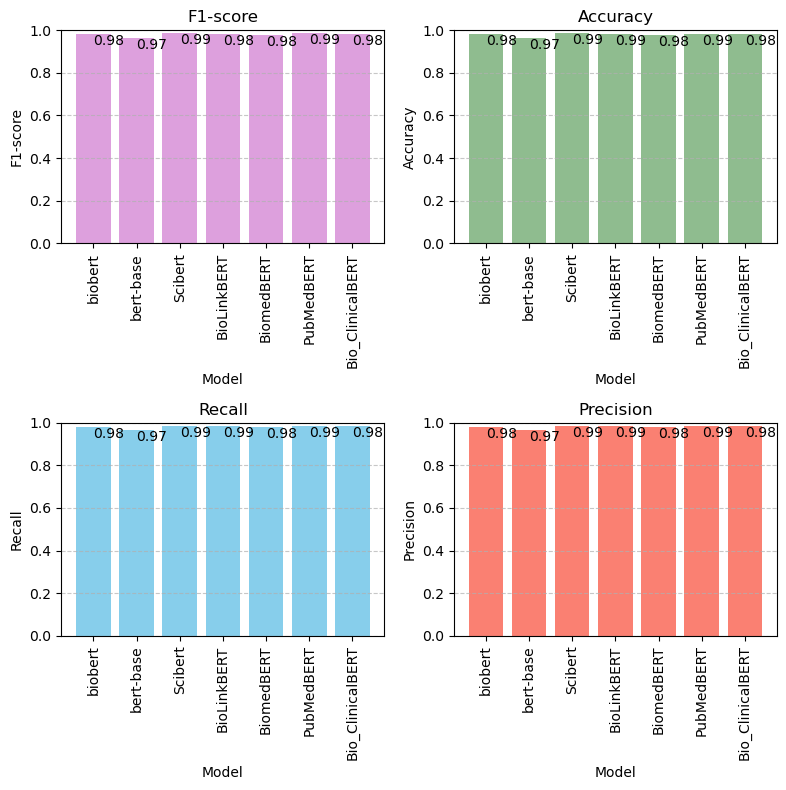

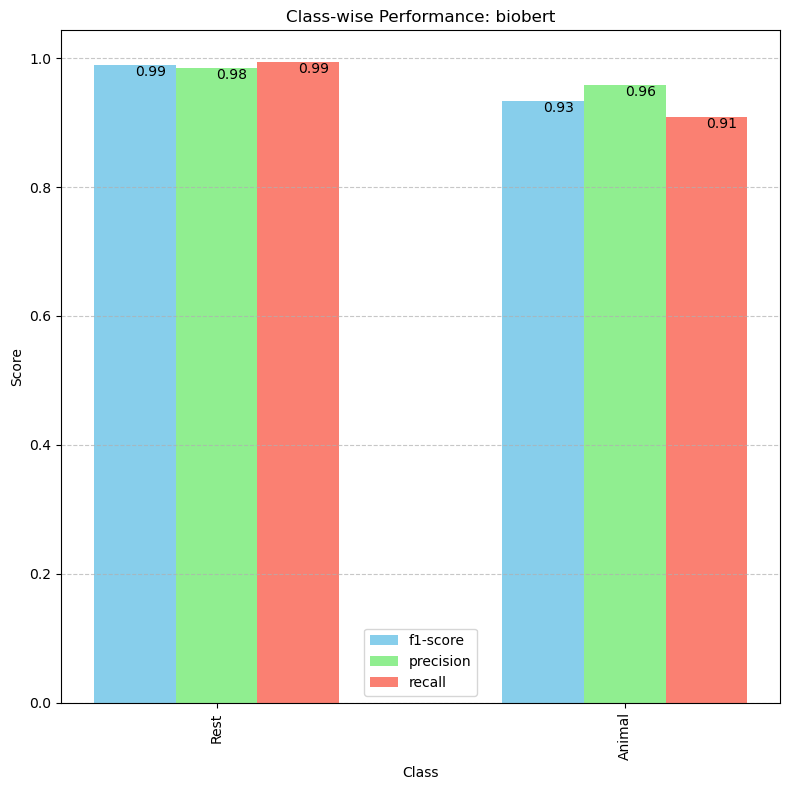

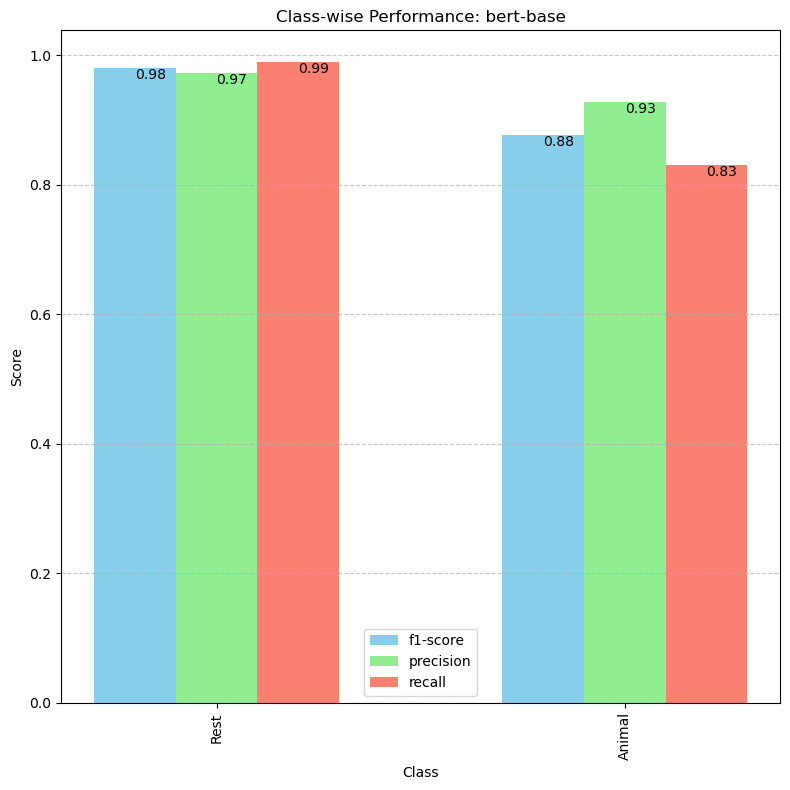

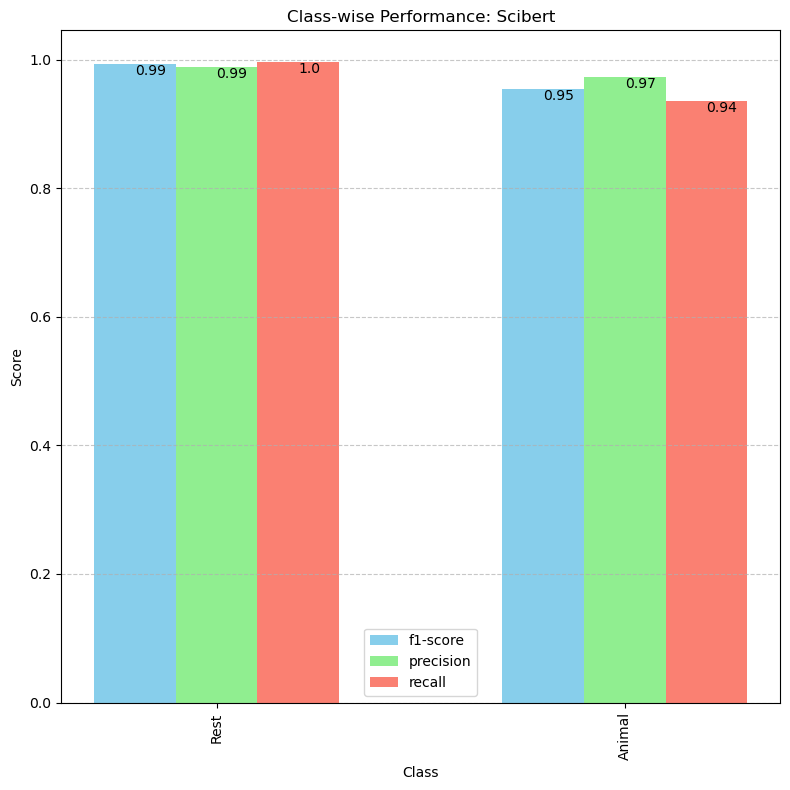

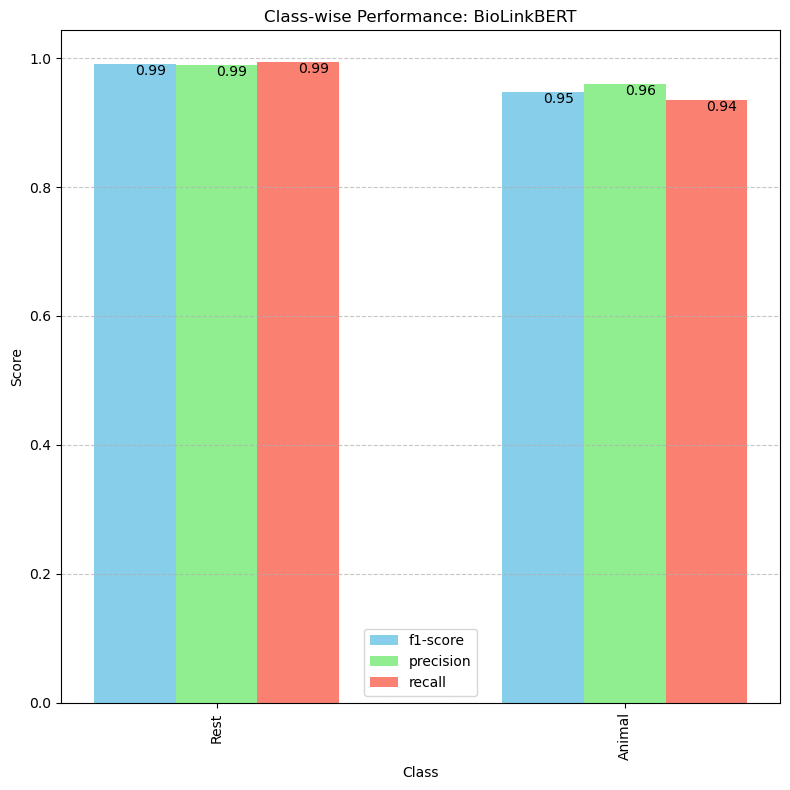

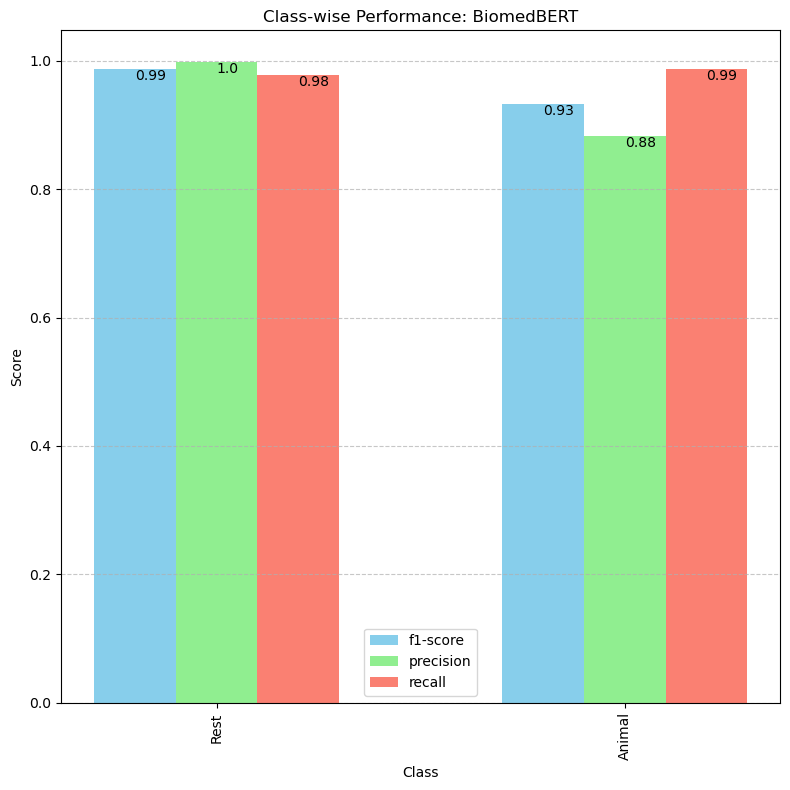

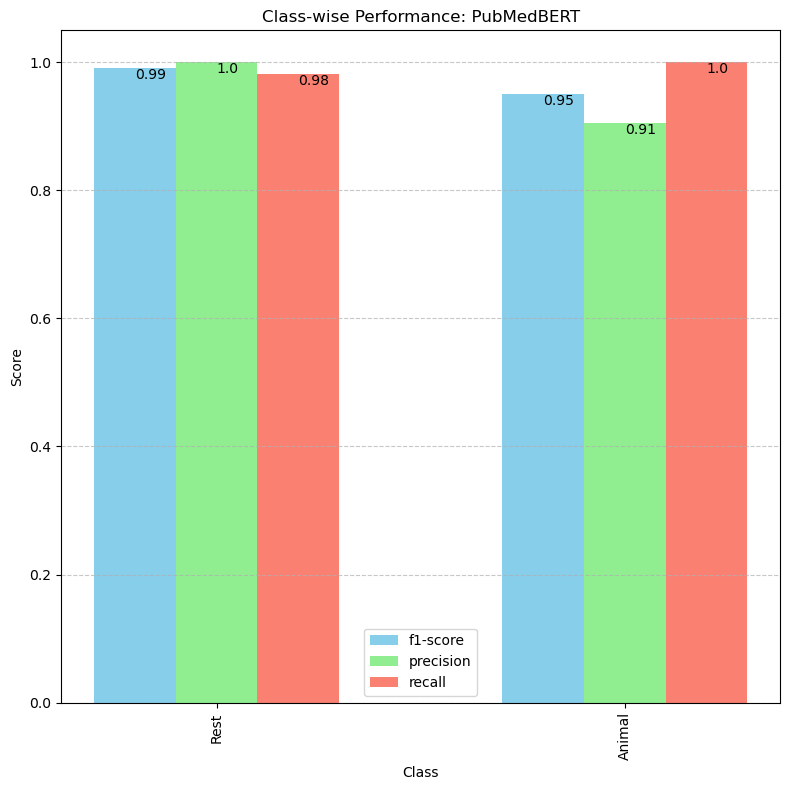

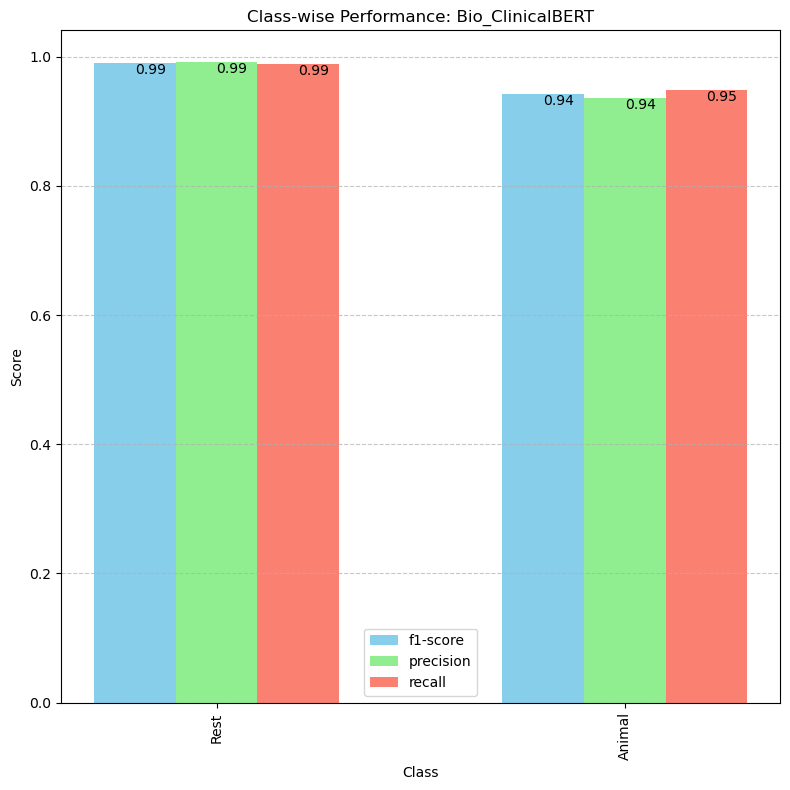

In [21]:
if __name__ == "__main__":
    main(classification_type='binary')

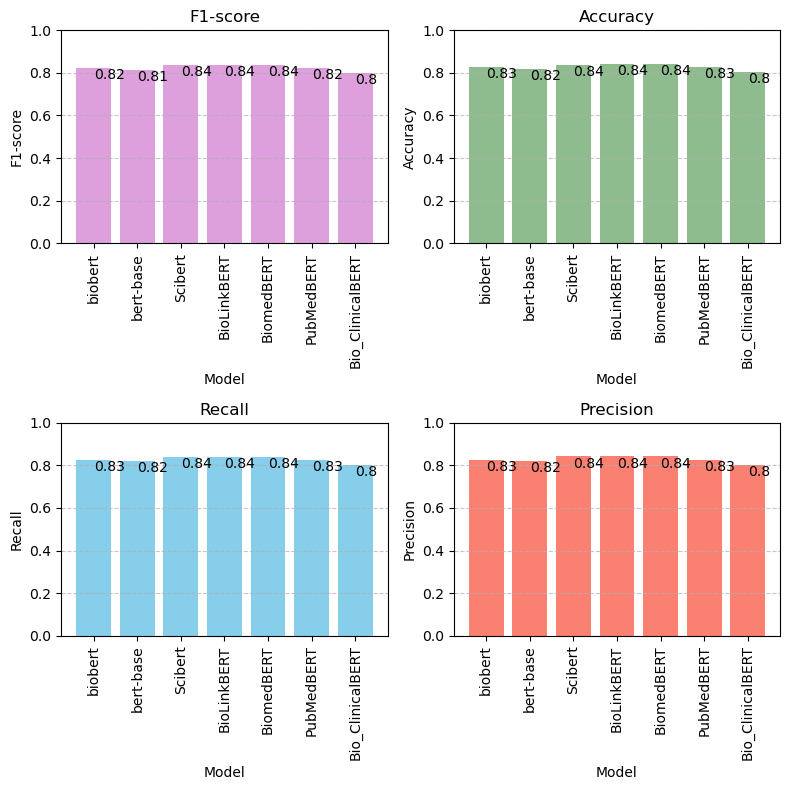

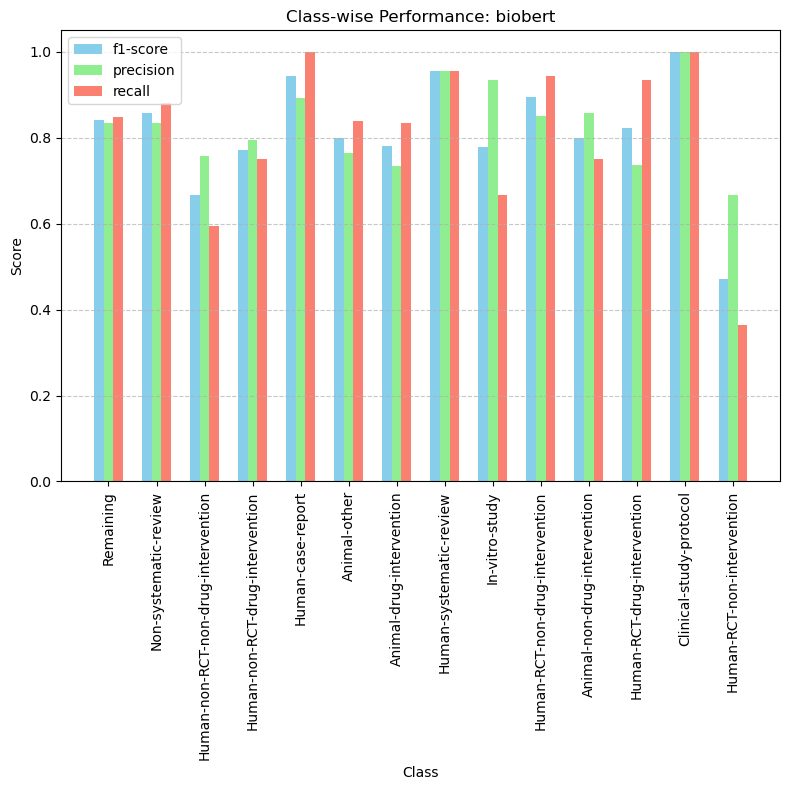

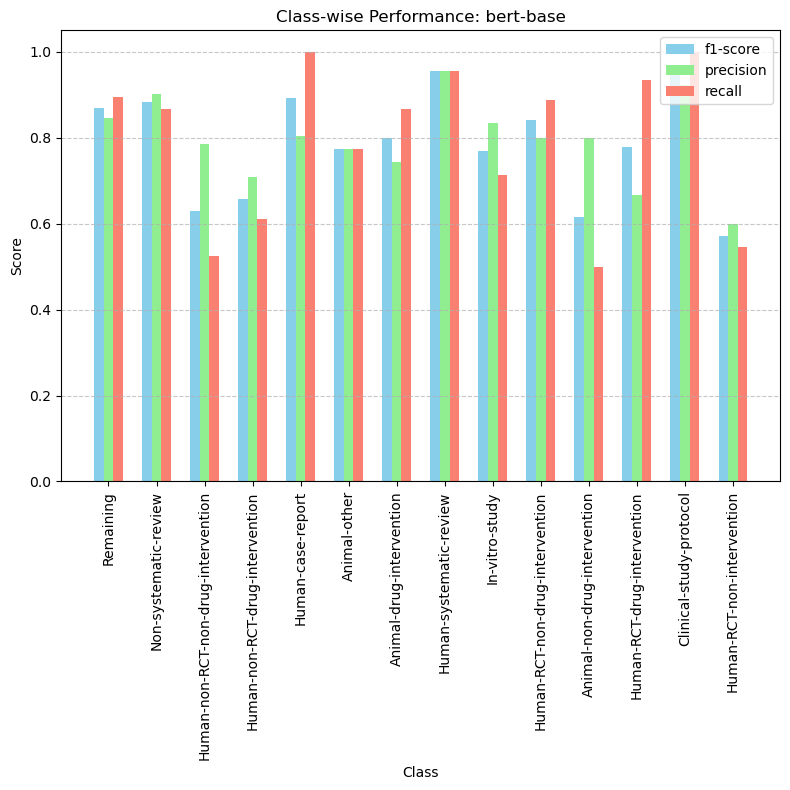

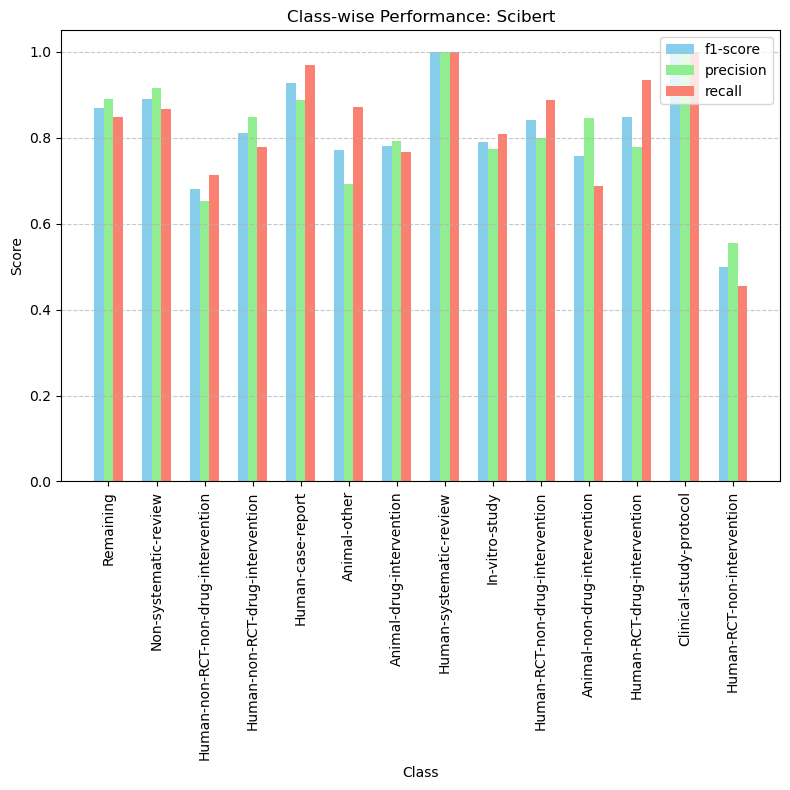

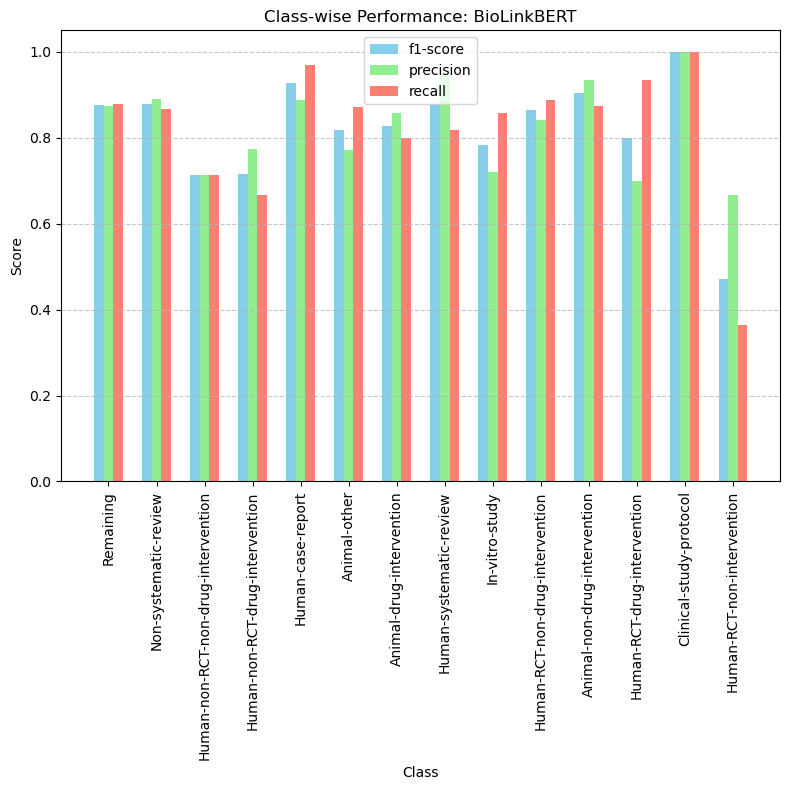

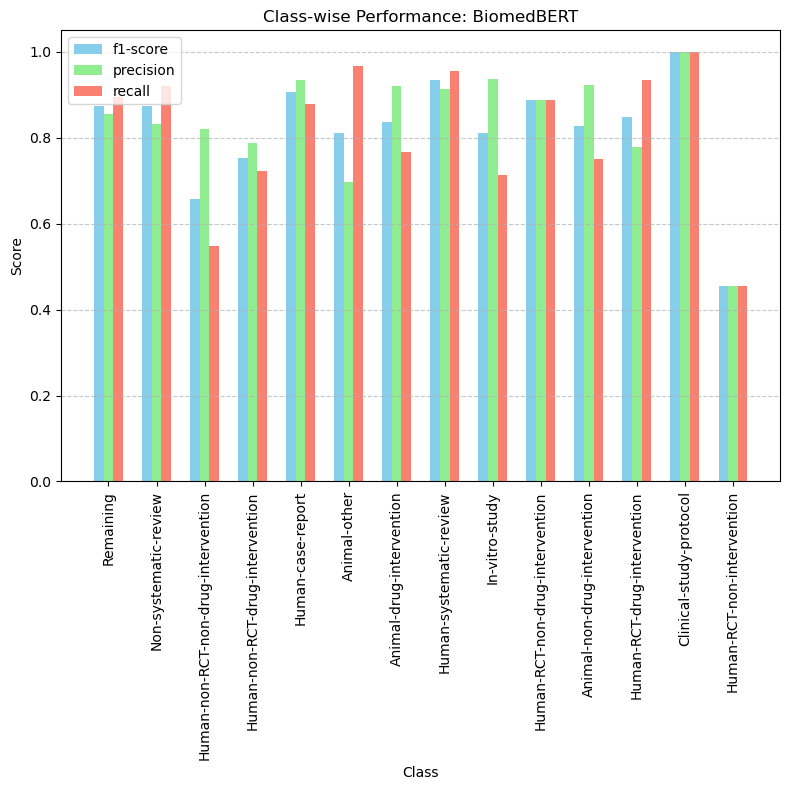

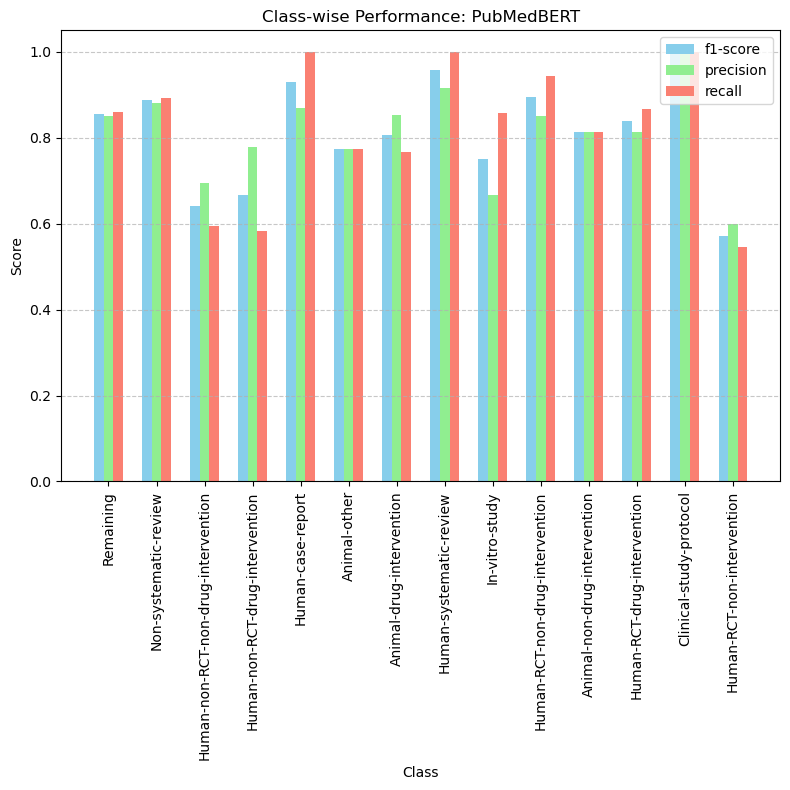

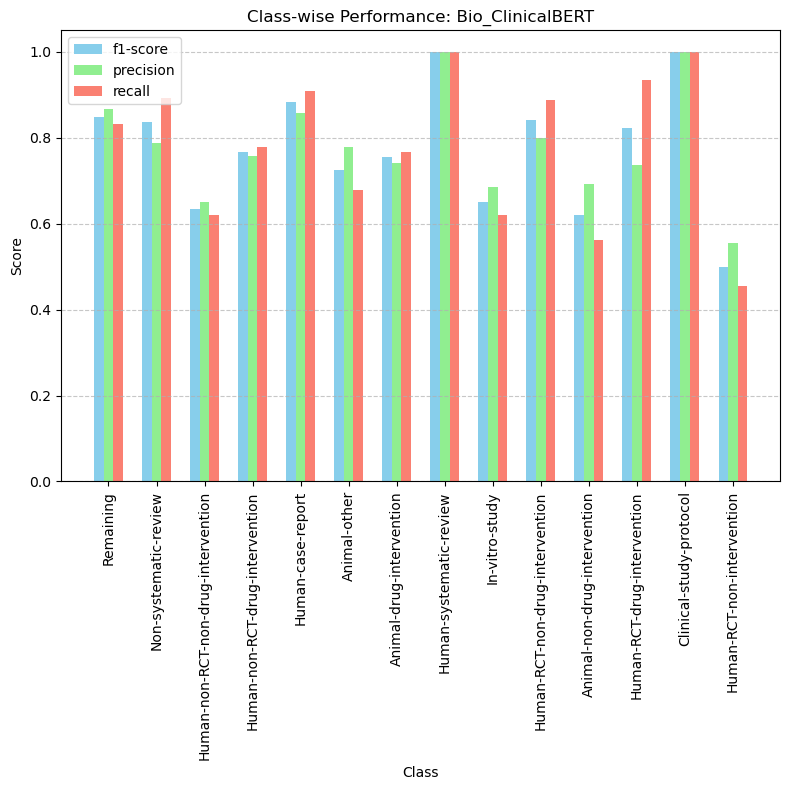

In [22]:
if __name__ == "__main__":
    # TODO select classification type (binary, multi)
    main(classification_type='multi')

# Compute results with confidence intervals

In [1]:
from confidenceinterval import classification_report_with_ci
from confidenceinterval.bootstrap import bootstrap_ci

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report

In [2]:
label_to_numerical = {
    'Remaining': 0,
    'Non-systematic-review': 1,
    'Human-non-RCT-non-drug-intervention': 2,
    'Human-non-RCT-drug-intervention': 3,
    'Human-case-report': 4,
    'Animal-other': 5,
    'Animal-drug-intervention': 6,
    'Human-systematic-review': 7,
    'In-vitro-study': 8,
    'Human-RCT-non-drug-intervention': 9,
    'Animal-non-drug-intervention': 10,
    'Human-RCT-drug-intervention': 11,
    'Clinical-study-protocol': 12,
    'Human-RCT-non-intervention': 13
}


numerical_to_label = {v: f"{k}" for k, v in label_to_numerical.items()}
numerical_to_label

{0: 'Remaining',
 1: 'Non-systematic-review',
 2: 'Human-non-RCT-non-drug-intervention',
 3: 'Human-non-RCT-drug-intervention',
 4: 'Human-case-report',
 5: 'Animal-other',
 6: 'Animal-drug-intervention',
 7: 'Human-systematic-review',
 8: 'In-vitro-study',
 9: 'Human-RCT-non-drug-intervention',
 10: 'Animal-non-drug-intervention',
 11: 'Human-RCT-drug-intervention',
 12: 'Clinical-study-protocol',
 13: 'Human-RCT-non-intervention'}

In [3]:
def evaluate_predictions_with_ci(model, df, true_col, prediction_col, label_to_numerical, numerical_to_label, digits=3):
    report_dfs = []
    summary_stats = []

    # Extract arrays for evaluation
    y_true = df[true_col].values
    y_pred = df[prediction_col].values
    cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
    report = classification_report_with_ci(y_true, y_pred, numerical_to_label_map=numerical_to_label, round_ndigits=digits)
    
    # Create DataFrame from report
    report_df = pd.DataFrame(report)
    report_dfs.append(report_df)
    
    # Extract summary statistics
    report_df.set_index('class', inplace=True)
    summary = report_df.loc['weighted avg', ['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI']].to_dict()
    summary_stats.append(summary)

    # Plotting normalized confusion matrix
    plt.figure(figsize=(12, 7.5))
    ax = sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
    plt.title(f'{model}', fontsize=14)
    plt.xlabel('Predicted', fontsize=13)
    plt.ylabel('True', fontsize=13)

    # Add an inset with label mapping
    textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    plt.tight_layout()
    plt.savefig(f'./{model}.pdf')
    plt.show()

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)
    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)

    return all_reports_df, summary_df

# SciBERT

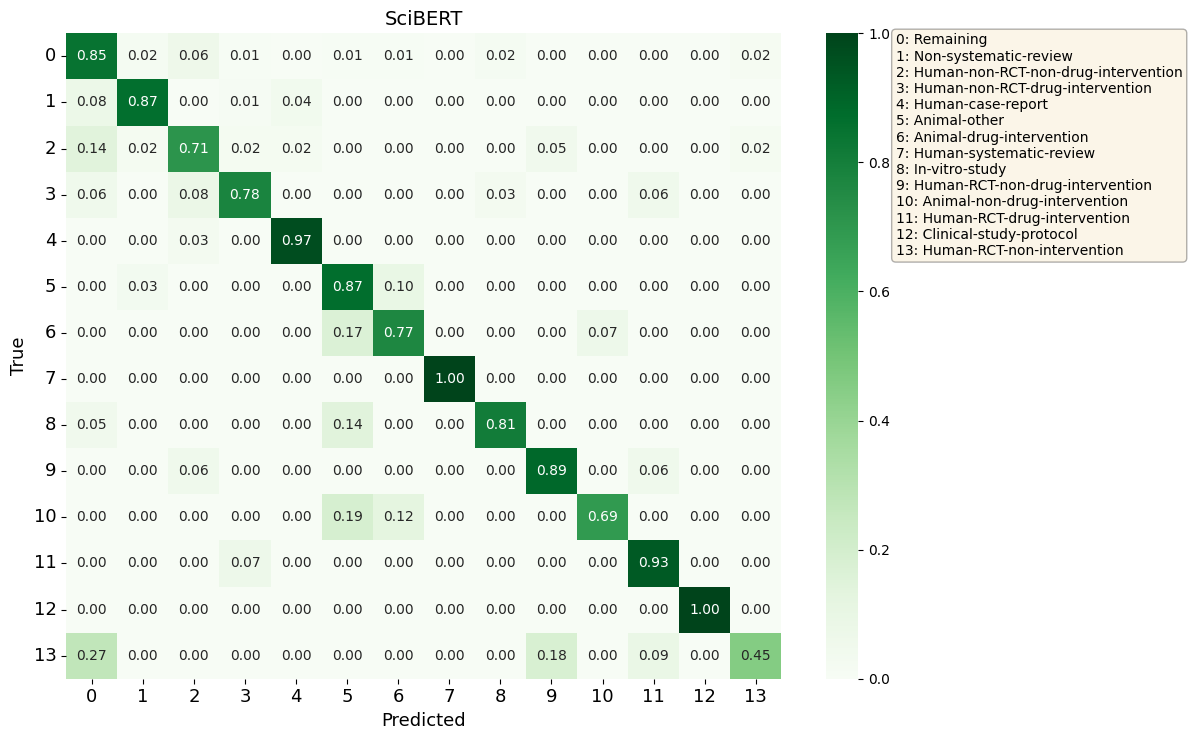

In [30]:
model = 'SciBERT' # TODO select model name
df = pd.read_csv('./../../models/transformers/evaluations/multi/predictions/Scibert.csv')
target_col = 'true_label'
prediction_col = 'prediction'
all_reports_df_scibert, summary_df_scibert = evaluate_predictions_with_ci(model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

In [31]:
all_reports_df_scibert

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support
class,,,,,,,,,
Remaining,0.890,0.849,0.869,0.918,"(0.833, 0.929)","(0.788, 0.895)","(0.825, 0.913)","(0.891, 0.938)",172
Non-systematic-review,0.915,0.867,0.890,0.970,"(0.828, 0.961)","(0.772, 0.926)","(0.833, 0.948)","(0.952, 0.981)",75
Human-non-RCT-non-drug-intervention,0.652,0.714,0.682,0.948,"(0.508, 0.773)","(0.564, 0.828)","(0.569, 0.794)","(0.925, 0.963)",42
Human-non-RCT-drug-intervention,0.848,0.778,0.812,0.976,"(0.691, 0.933)","(0.619, 0.883)","(0.709, 0.914)","(0.959, 0.986)",36
Human-case-report,0.889,0.970,0.928,0.991,"(0.747, 0.956)","(0.847, 0.995)","(0.862, 0.994)","(0.978, 0.996)",33
Animal-other,0.692,0.871,0.771,0.970,"(0.536, 0.814)","(0.711, 0.949)","(0.661, 0.882)","(0.952, 0.981)",31
Animal-drug-intervention,0.793,0.767,0.780,0.976,"(0.616, 0.902)","(0.591, 0.882)","(0.661, 0.898)","(0.959, 0.986)",30
Human-systematic-review,1.000,1.000,1.000,1.000,"(0.851, 1.0)","(0.851, 1.0)","(1.0, 1.0)","(0.993, 1.0)",22
In-vitro-study,0.773,0.810,0.791,0.983,"(0.566, 0.899)","(0.6, 0.923)","(0.655, 0.926)","(0.968, 0.991)",21


In [32]:
summary_df_scibert

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI
0,0.843,"(0.806, 0.868)",0.839,"(0.807, 0.869)",0.839,"(0.806, 0.869)",0.839,"(0.805, 0.869)"


# BERT-base

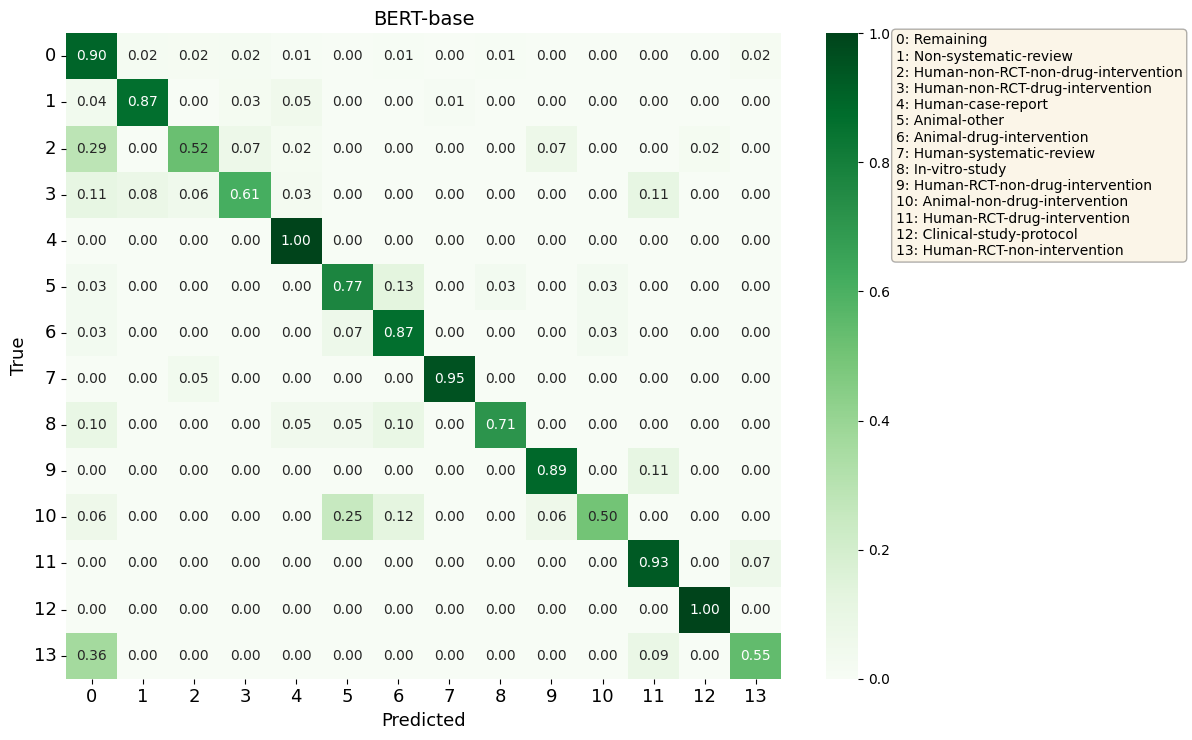

   precision    precision CI  recall       recall CI  f1-score  \
0       0.82  (0.781, 0.848)    0.82  (0.785, 0.852)     0.815   

      f1-score CI  accuracy    accuracy CI  
0  (0.777, 0.848)      0.82  (0.785, 0.85)  
                                     precision  recall  f1-score  accuracy  \
class                                                                        
Remaining                                0.846   0.895     0.870     0.914   
Non-systematic-review                    0.903   0.867     0.884     0.968   
Human-non-RCT-non-drug-intervention      0.786   0.524     0.629     0.951   
Human-non-RCT-drug-intervention          0.710   0.611     0.657     0.957   
Human-case-report                        0.805   1.000     0.892     0.985   
Animal-other                             0.774   0.774     0.774     0.974   
Animal-drug-intervention                 0.743   0.867     0.800     0.976   
Human-systematic-review                  0.955   0.955     0.955     0.996 

In [4]:
model = 'BERT-base'
df = pd.read_csv('./../../models/transformers/evaluations/multi/predictions/bert-base.csv')
target_col = 'true_label'
prediction_col = 'prediction'
all_reports_df, summary_df = evaluate_predictions_with_ci(model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)
print(summary_df)
print(all_reports_df)

# BioBERT

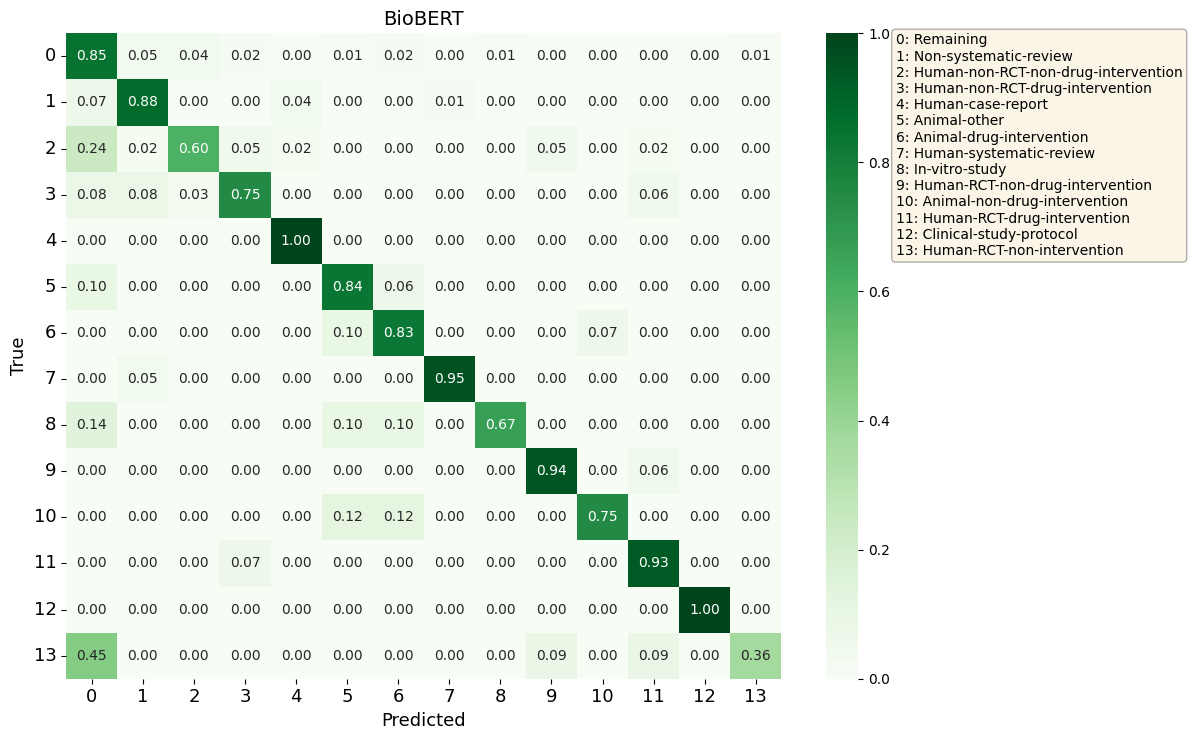

In [5]:
model = 'BioBERT' # TODO select model name
df = pd.read_csv('./../../models/transformers/evaluations/multi/predictions/biobert.csv')
target_col = 'true_label'
prediction_col = 'prediction'
all_reports_df, summary_df = evaluate_predictions_with_ci(model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

In [6]:
summary_df

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI
0,0.827,"(0.789, 0.855)",0.828,"(0.794, 0.858)",0.824,"(0.788, 0.855)",0.828,"(0.794, 0.858)"


In [7]:
all_reports_df

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support
class,,,,,,,,,
Remaining,0.834,0.849,0.841,0.897,"(0.772, 0.882)","(0.788, 0.895)","(0.795, 0.888)","(0.868, 0.92)",172
Non-systematic-review,0.835,0.880,0.857,0.959,"(0.739, 0.901)","(0.787, 0.936)","(0.794, 0.92)","(0.938, 0.973)",75
Human-non-RCT-non-drug-intervention,0.758,0.595,0.667,0.953,"(0.59, 0.872)","(0.445, 0.73)","(0.543, 0.79)","(0.932, 0.968)",42
Human-non-RCT-drug-intervention,0.794,0.750,0.771,0.970,"(0.632, 0.897)","(0.589, 0.862)","(0.661, 0.882)","(0.952, 0.981)",36
Human-case-report,0.892,1.000,0.943,0.993,"(0.753, 0.957)","(0.896, 1.0)","(0.884, 1.001)","(0.981, 0.997)",33
Animal-other,0.765,0.839,0.800,0.976,"(0.6, 0.876)","(0.674, 0.929)","(0.692, 0.908)","(0.959, 0.986)",31
Animal-drug-intervention,0.735,0.833,0.781,0.974,"(0.569, 0.854)","(0.664, 0.927)","(0.668, 0.895)","(0.956, 0.984)",30
Human-systematic-review,0.955,0.955,0.955,0.996,"(0.782, 0.992)","(0.782, 0.992)","(0.89, 1.019)","(0.986, 0.999)",22
In-vitro-study,0.933,0.667,0.778,0.985,"(0.702, 0.988)","(0.454, 0.828)","(0.627, 0.929)","(0.971, 0.992)",21


# PubMedBERT

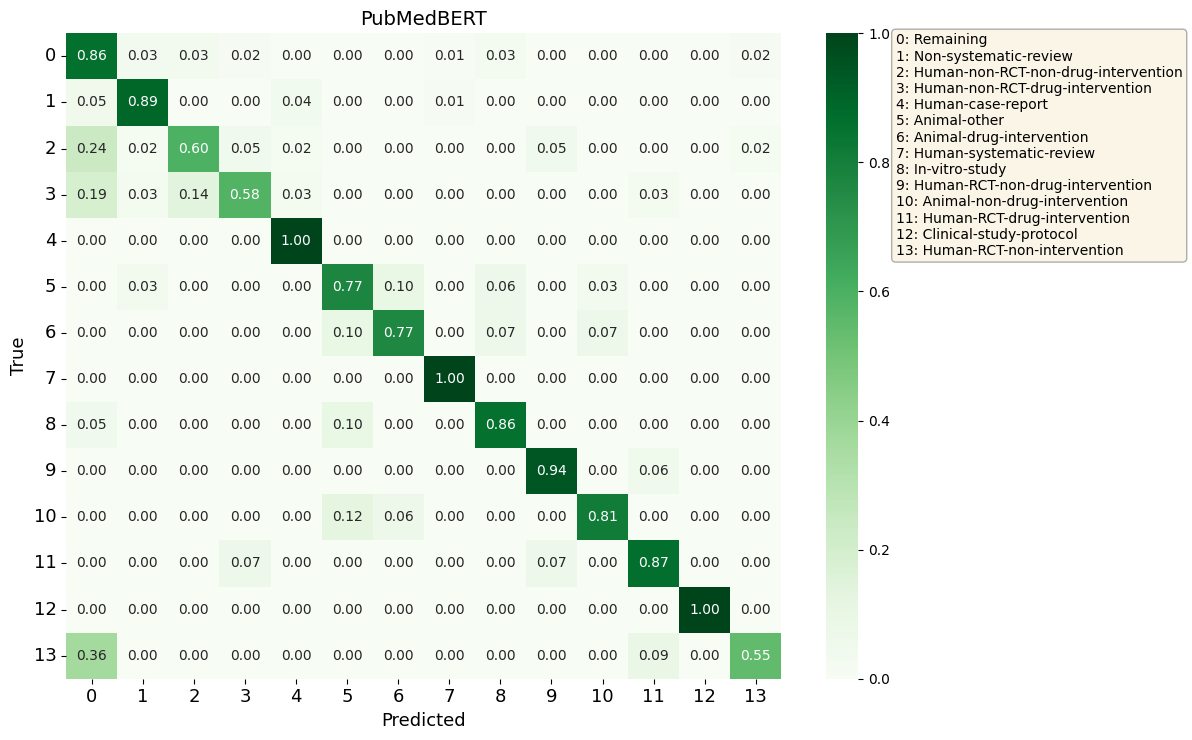

In [8]:
model = 'PubMedBERT' # TODO select model name
df = pd.read_csv('./../../models/transformers/evaluations/multi/predictions/PubMedBERT.csv')
target_col = 'true_label'
prediction_col = 'prediction'
all_reports_df, summary_df = evaluate_predictions_with_ci(model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

In [9]:
summary_df

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI
0,0.826,"(0.786, 0.853)",0.828,"(0.794, 0.858)",0.824,"(0.79, 0.856)",0.828,"(0.794, 0.858)"


In [10]:
all_reports_df

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support
class,,,,,,,,,
Remaining,0.851,0.860,0.855,0.906,"(0.79, 0.896)","(0.801, 0.904)","(0.811, 0.9)","(0.879, 0.928)",172
Non-systematic-review,0.882,0.893,0.887,0.968,"(0.79, 0.936)","(0.803, 0.945)","(0.83, 0.945)","(0.95, 0.98)",75
Human-non-RCT-non-drug-intervention,0.694,0.595,0.641,0.948,"(0.531, 0.82)","(0.445, 0.73)","(0.516, 0.766)","(0.925, 0.963)",42
Human-non-RCT-drug-intervention,0.778,0.583,0.667,0.961,"(0.592, 0.894)","(0.422, 0.729)","(0.532, 0.802)","(0.941, 0.974)",36
Human-case-report,0.868,1.000,0.930,0.991,"(0.727, 0.942)","(0.896, 1.0)","(0.865, 0.994)","(0.978, 0.996)",33
Animal-other,0.774,0.774,0.774,0.974,"(0.602, 0.886)","(0.602, 0.886)","(0.657, 0.891)","(0.956, 0.984)",31
Animal-drug-intervention,0.852,0.767,0.807,0.979,"(0.675, 0.941)","(0.591, 0.882)","(0.693, 0.921)","(0.963, 0.988)",30
Human-systematic-review,0.917,1.000,0.957,0.996,"(0.742, 0.977)","(0.851, 1.0)","(0.894, 1.019)","(0.986, 0.999)",22
In-vitro-study,0.667,0.857,0.750,0.978,"(0.478, 0.814)","(0.654, 0.95)","(0.612, 0.888)","(0.961, 0.987)",21


# BiomedBERT

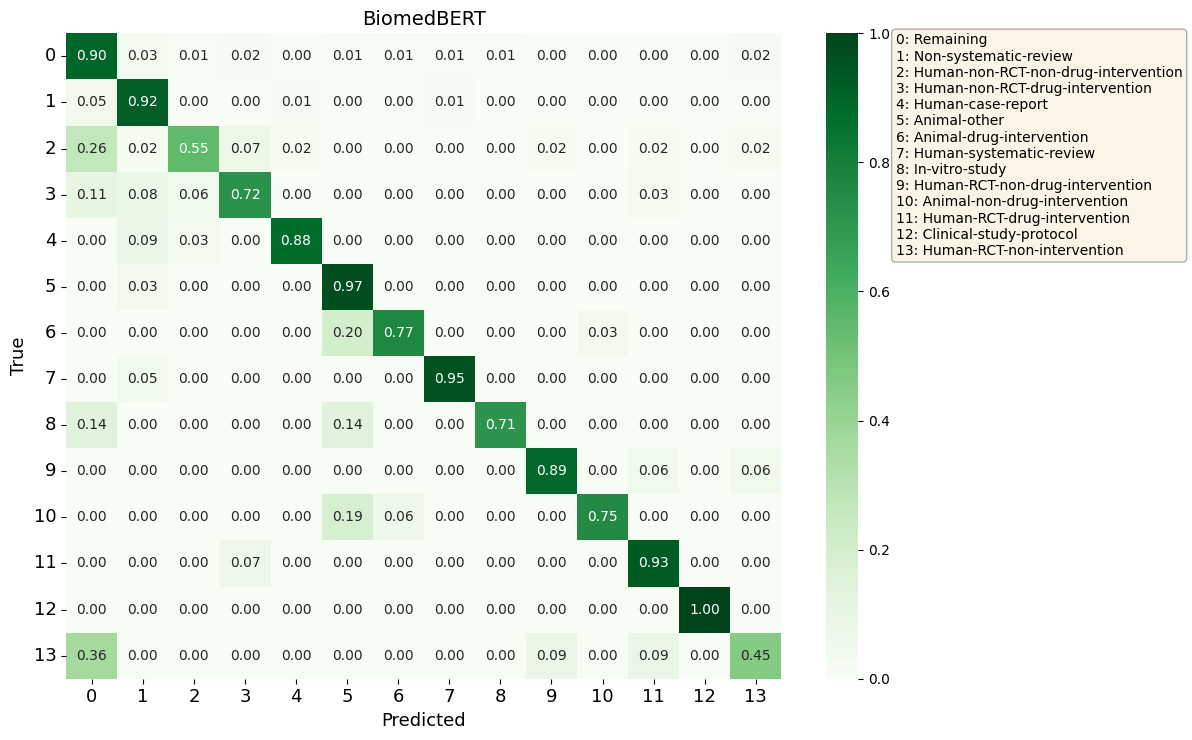

In [11]:
model = 'BiomedBERT' # TODO select model name
df = pd.read_csv('./../../models/transformers/evaluations/multi/predictions/BiomedBERT.csv')
target_col = 'true_label'
prediction_col = 'prediction'
all_reports_df, summary_df = evaluate_predictions_with_ci(model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

In [12]:
summary_df

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI
0,0.846,"(0.808, 0.872)",0.841,"(0.809, 0.871)",0.838,"(0.804, 0.868)",0.841,"(0.807, 0.871)"


In [13]:
all_reports_df

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support
class,,,,,,,,,
Remaining,0.856,0.895,0.875,0.918,"(0.797, 0.899)","(0.841, 0.933)","(0.833, 0.917)","(0.891, 0.938)",172
Non-systematic-review,0.831,0.920,0.873,0.963,"(0.737, 0.897)","(0.836, 0.963)","(0.815, 0.932)","(0.943, 0.976)",75
Human-non-RCT-non-drug-intervention,0.821,0.548,0.657,0.955,"(0.644, 0.921)","(0.399, 0.688)","(0.528, 0.786)","(0.934, 0.97)",42
Human-non-RCT-drug-intervention,0.788,0.722,0.754,0.968,"(0.622, 0.893)","(0.56, 0.842)","(0.639, 0.869)","(0.95, 0.98)",36
Human-case-report,0.935,0.879,0.906,0.989,"(0.793, 0.982)","(0.727, 0.952)","(0.829, 0.984)","(0.976, 0.995)",33
Animal-other,0.698,0.968,0.811,0.974,"(0.549, 0.814)","(0.838, 0.994)","(0.712, 0.91)","(0.956, 0.984)",31
Animal-drug-intervention,0.920,0.767,0.836,0.983,"(0.75, 0.978)","(0.591, 0.882)","(0.729, 0.944)","(0.968, 0.991)",30
Human-systematic-review,0.913,0.955,0.933,0.994,"(0.732, 0.976)","(0.782, 0.992)","(0.856, 1.011)","(0.984, 0.998)",22
In-vitro-study,0.937,0.714,0.811,0.987,"(0.717, 0.989)","(0.5, 0.862)","(0.672, 0.95)","(0.973, 0.994)",21


# BioLinkBERT

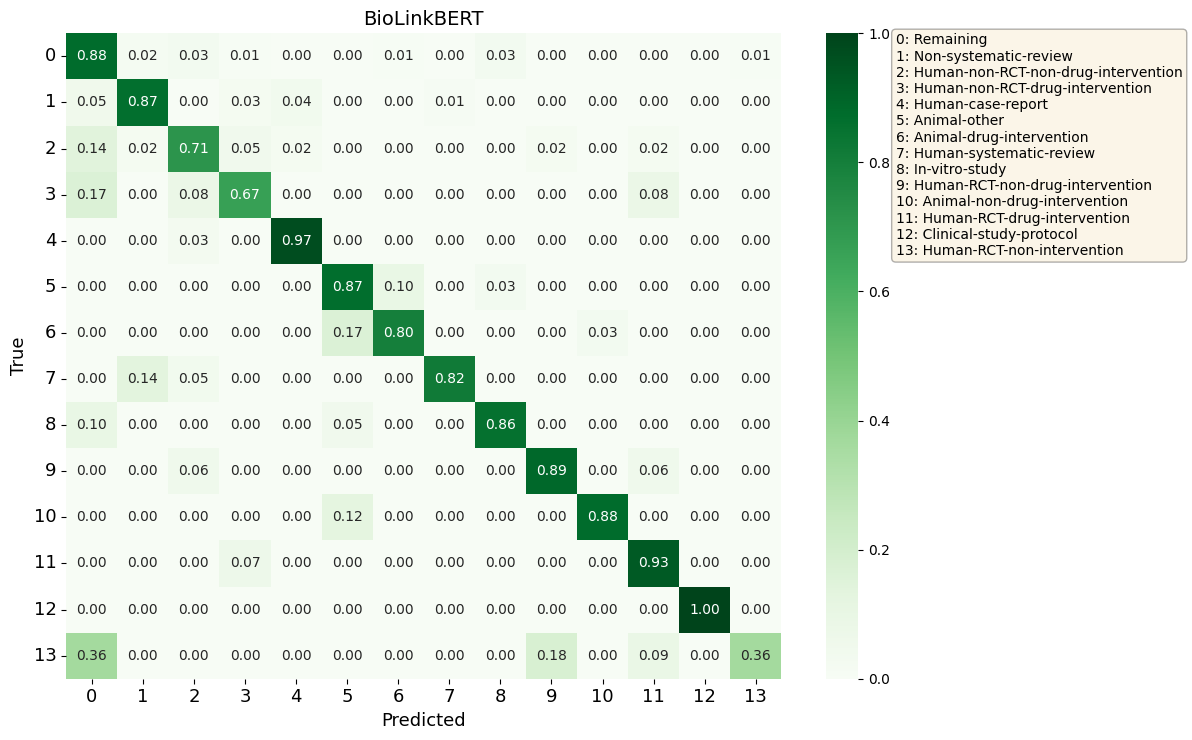

In [14]:
model = 'BioLinkBERT' # TODO select model name
df = pd.read_csv('./../../models/transformers/evaluations/multi/predictions/BioLinkBERT.csv')
target_col = 'true_label'
prediction_col = 'prediction'
all_reports_df, summary_df = evaluate_predictions_with_ci(model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

In [15]:
summary_df

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI
0,0.842,"(0.803, 0.867)",0.841,"(0.807, 0.869)",0.839,"(0.805, 0.869)",0.841,"(0.809, 0.871)"


In [16]:
all_reports_df

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support
class,,,,,,,,,
Remaining,0.873,0.878,0.875,0.919,"(0.815, 0.915)","(0.821, 0.919)","(0.833, 0.918)","(0.893, 0.94)",172
Non-systematic-review,0.890,0.867,0.878,0.966,"(0.798, 0.943)","(0.772, 0.926)","(0.819, 0.938)","(0.947, 0.979)",75
Human-non-RCT-non-drug-intervention,0.714,0.714,0.714,0.955,"(0.564, 0.828)","(0.564, 0.828)","(0.604, 0.825)","(0.934, 0.97)",42
Human-non-RCT-drug-intervention,0.774,0.667,0.716,0.964,"(0.602, 0.886)","(0.503, 0.798)","(0.593, 0.84)","(0.945, 0.977)",36
Human-case-report,0.889,0.970,0.928,0.991,"(0.747, 0.956)","(0.847, 0.995)","(0.862, 0.994)","(0.978, 0.996)",33
Animal-other,0.771,0.871,0.818,0.978,"(0.61, 0.879)","(0.711, 0.949)","(0.715, 0.921)","(0.961, 0.987)",31
Animal-drug-intervention,0.857,0.800,0.828,0.981,"(0.685, 0.943)","(0.627, 0.905)","(0.72, 0.935)","(0.966, 0.99)",30
Human-systematic-review,0.947,0.818,0.878,0.991,"(0.754, 0.991)","(0.615, 0.927)","(0.77, 0.986)","(0.978, 0.996)",22
In-vitro-study,0.720,0.857,0.783,0.981,"(0.524, 0.857)","(0.654, 0.95)","(0.65, 0.916)","(0.966, 0.99)",21


# Bio_ClinicalBERT

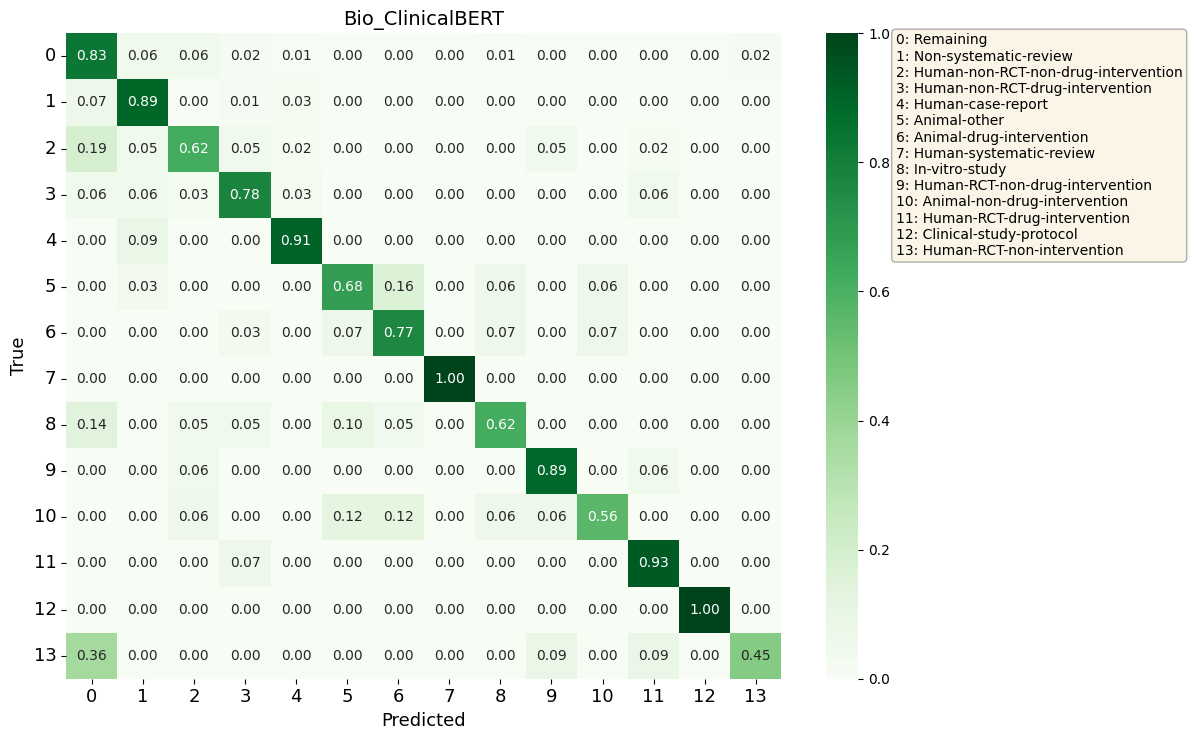

In [17]:
model = 'Bio_ClinicalBERT' # TODO select model name
df = pd.read_csv('./../../models/transformers/evaluations/multi/predictions/Bio_ClinicalBERT.csv')
target_col = 'true_label'
prediction_col = 'prediction'
all_reports_df, summary_df = evaluate_predictions_with_ci(model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

In [18]:
summary_df

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI
0,0.802,"(0.762, 0.832)",0.803,"(0.768, 0.835)",0.801,"(0.764, 0.835)",0.803,"(0.768, 0.835)"


In [19]:
all_reports_df

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support
class,,,,,,,,,
Remaining,0.867,0.831,0.849,0.904,"(0.806, 0.91)","(0.768, 0.88)","(0.802, 0.895)","(0.877, 0.927)",172
Non-systematic-review,0.788,0.893,0.838,0.951,"(0.69, 0.862)","(0.803, 0.945)","(0.772, 0.903)","(0.93, 0.967)",75
Human-non-RCT-non-drug-intervention,0.650,0.619,0.634,0.944,"(0.495, 0.779)","(0.468, 0.75)","(0.512, 0.756)","(0.921, 0.96)",42
Human-non-RCT-drug-intervention,0.757,0.778,0.767,0.968,"(0.599, 0.866)","(0.619, 0.883)","(0.658, 0.876)","(0.95, 0.98)",36
Human-case-report,0.857,0.909,0.882,0.985,"(0.706, 0.937)","(0.764, 0.969)","(0.799, 0.966)","(0.971, 0.992)",33
Animal-other,0.778,0.677,0.724,0.970,"(0.592, 0.894)","(0.501, 0.814)","(0.593, 0.855)","(0.952, 0.981)",31
Animal-drug-intervention,0.742,0.767,0.754,0.972,"(0.568, 0.863)","(0.591, 0.882)","(0.632, 0.876)","(0.954, 0.983)",30
Human-systematic-review,1.000,1.000,1.000,1.000,"(0.851, 1.0)","(0.851, 1.0)","(1.0, 1.0)","(0.993, 1.0)",22
In-vitro-study,0.684,0.619,0.650,0.974,"(0.46, 0.846)","(0.409, 0.792)","(0.478, 0.822)","(0.956, 0.984)",21


# GPT-3.5

/Users/shtosti/Dropbox/work/current/RA_CRS/StudyTypeTeller/.venv/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shtosti/Dropbox/work/current/RA_CRS/StudyTypeTeller/.venv/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shtosti/Dropbox/work/current/RA_CRS/StudyTypeTeller/.venv/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shtosti/Dropbox/work/current/RA_CRS/StudyTypeTeller/.venv/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shtosti/Dropbox/work/current/RA_CRS/StudyTypeTeller/.venv/lib/python3.12/site-packages/co

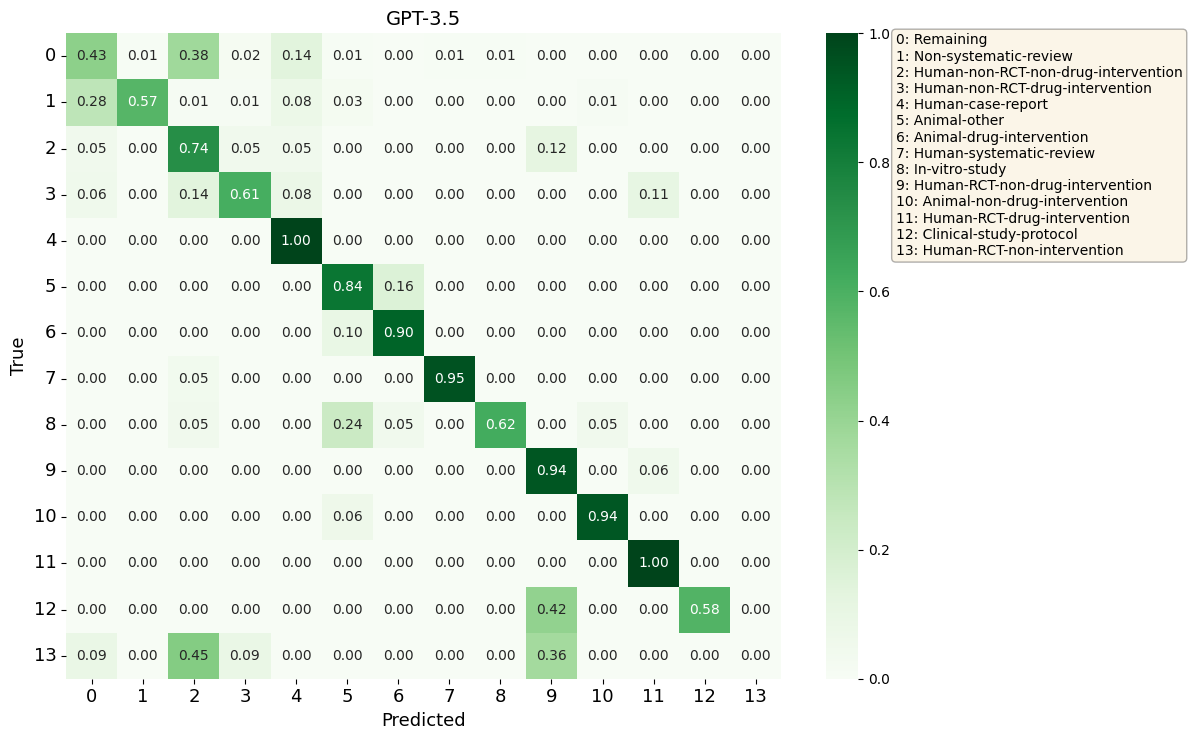

In [24]:
model = 'GPT-3.5' # TODO select model name

df = pd.read_csv('./top_performing_herarchical_GPT_structured.csv')
target_col = 'multi_label'
prediction_col = 'gpt_3_predictions_P2_HIERARCHY_numerical'


all_reports_df_gpt3, summary_df_gpt3 = evaluate_predictions_with_ci(model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

In [25]:
summary_df_gpt3

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI
0,0.741,"(0.698, 0.772)",0.644,"(0.603, 0.684)",0.645,"(0.603, 0.685)",0.644,"(0.605, 0.685)"


In [26]:
all_reports_df_gpt3

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support
class,,,,,,,,,
Remaining,0.740,0.430,0.544,0.768,"(0.646, 0.816)","(0.359, 0.505)","(0.473, 0.615)","(0.73, 0.802)",172
Non-systematic-review,0.977,0.573,0.723,0.938,"(0.882, 0.996)","(0.461, 0.679)","(0.631, 0.814)","(0.914, 0.956)",75
Human-non-RCT-non-drug-intervention,0.284,0.738,0.411,0.833,"(0.208, 0.375)","(0.589, 0.847)","(0.311, 0.51)","(0.799, 0.863)",42
Human-non-RCT-drug-intervention,0.759,0.611,0.677,0.961,"(0.579, 0.878)","(0.449, 0.752)","(0.545, 0.808)","(0.941, 0.974)",36
Human-case-report,0.485,1.000,0.653,0.934,"(0.371, 0.602)","(0.896, 1.0)","(0.546, 0.761)","(0.91, 0.952)",33
Animal-other,0.667,0.839,0.743,0.966,"(0.51, 0.794)","(0.674, 0.929)","(0.627, 0.859)","(0.947, 0.979)",31
Animal-drug-intervention,0.818,0.900,0.857,0.983,"(0.656, 0.914)","(0.744, 0.965)","(0.762, 0.952)","(0.968, 0.991)",30
Human-systematic-review,0.955,0.955,0.955,0.996,"(0.782, 0.992)","(0.782, 0.992)","(0.89, 1.019)","(0.986, 0.999)",22
In-vitro-study,0.867,0.619,0.722,0.981,"(0.621, 0.963)","(0.409, 0.792)","(0.556, 0.888)","(0.966, 0.99)",21


# GPT-4

/Users/shtosti/Dropbox/work/current/RA_CRS/StudyTypeTeller/.venv/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/Users/shtosti/Dropbox/work/current/RA_CRS/StudyTypeTeller/.venv/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)
/Users/shtosti/Dropbox/work/current/RA_CRS/StudyTypeTeller/.venv/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:286: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), recall_macro + \
/Users/shtosti/Dropbox/work/current/RA_CRS/StudyTypeTeller/.venv/lib/python3.12/site-packages/confidenceinterval/takahashi_methods.py:287: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


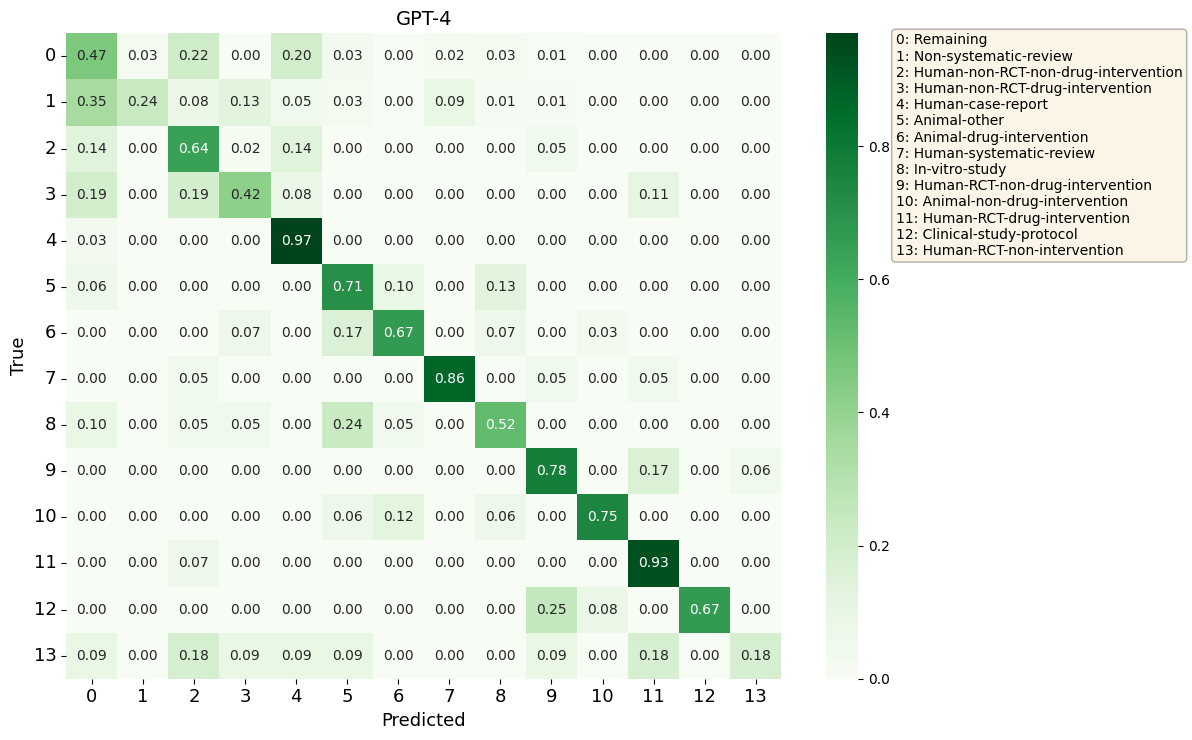

In [27]:
model = 'GPT-4' # TODO select model name

df = pd.read_csv('./top_performing_herarchical_GPT_structured.csv')
target_col = 'multi_label'
prediction_col = 'gpt_4_predictions_P2_HIERARCHY_numerical'


all_reports_df_gpt4, summary_df_gpt4 = evaluate_predictions_with_ci(model, df, target_col, prediction_col, label_to_numerical, numerical_to_label, digits=3)

In [28]:
summary_df_gpt4

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI
0,0.617,"(0.564, 0.656)",0.551,"(0.507, 0.592)",0.54,"(0.496, 0.585)",0.551,"(0.509, 0.592)"


In [29]:
all_reports_df_gpt4

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support
class,,,,,,,,,
Remaining,0.640,0.465,0.539,0.743,"(0.553, 0.719)","(0.392, 0.54)","(0.47, 0.607)","(0.705, 0.779)",172
Non-systematic-review,0.783,0.240,0.367,0.884,"(0.581, 0.903)","(0.158, 0.348)","(0.244, 0.491)","(0.854, 0.908)",75
Human-non-RCT-non-drug-intervention,0.329,0.643,0.435,0.869,"(0.237, 0.437)","(0.492, 0.77)","(0.326, 0.545)","(0.838, 0.895)",42
Human-non-RCT-drug-intervention,0.500,0.417,0.455,0.933,"(0.332, 0.668)","(0.271, 0.578)","(0.305, 0.604)","(0.908, 0.951)",36
Human-case-report,0.400,0.970,0.566,0.908,"(0.3, 0.51)","(0.847, 0.995)","(0.457, 0.675)","(0.881, 0.93)",33
Animal-other,0.524,0.710,0.603,0.946,"(0.377, 0.666)","(0.534, 0.839)","(0.47, 0.736)","(0.923, 0.962)",31
Animal-drug-intervention,0.769,0.667,0.714,0.970,"(0.579, 0.89)","(0.488, 0.808)","(0.579, 0.849)","(0.952, 0.981)",30
Human-systematic-review,0.633,0.864,0.731,0.974,"(0.455, 0.781)","(0.667, 0.953)","(0.594, 0.867)","(0.956, 0.984)",22
In-vitro-study,0.458,0.524,0.489,0.957,"(0.279, 0.649)","(0.324, 0.717)","(0.309, 0.668)","(0.936, 0.971)",21


-----
# Plotting performance with error bars

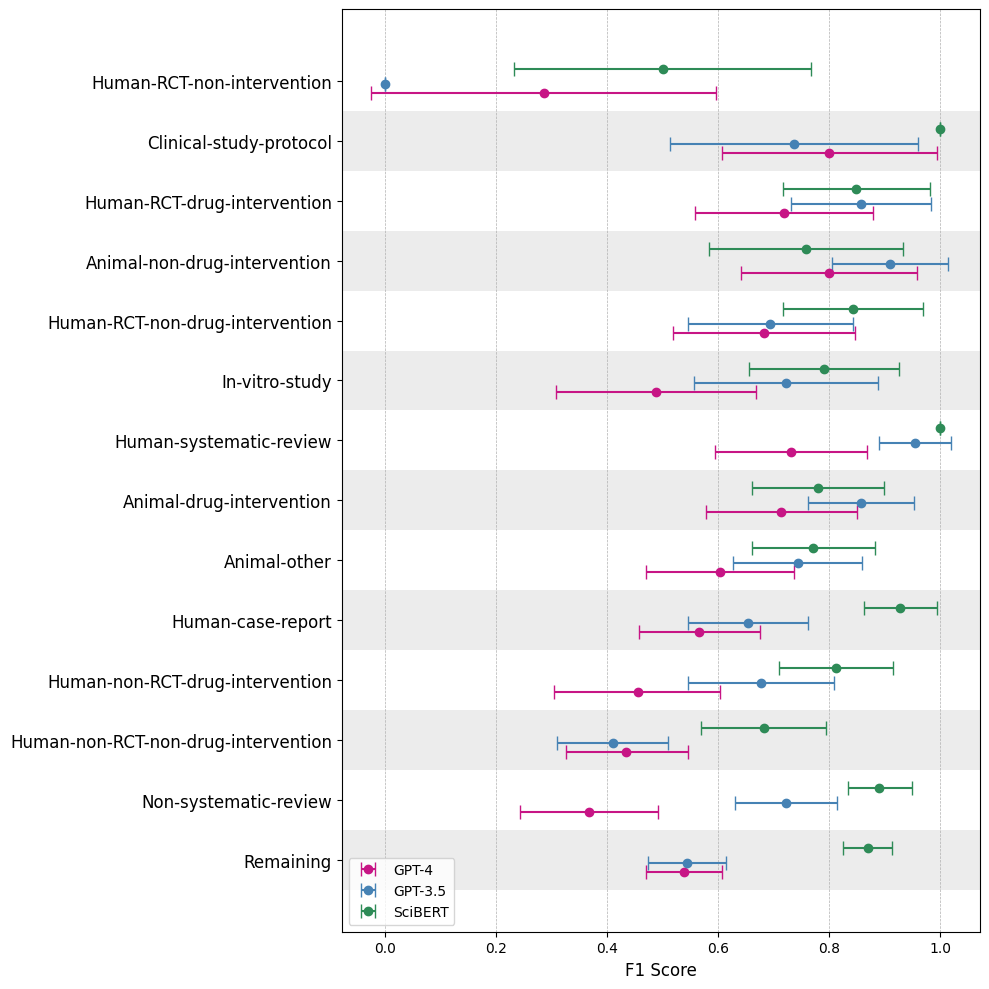

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only the specified classes (omit av. metric lines)
label_to_numerical = {
    'Remaining': 0,
    'Non-systematic-review': 1,
    'Human-non-RCT-non-drug-intervention': 2,
    'Human-non-RCT-drug-intervention': 3,
    'Human-case-report': 4,
    'Animal-other': 5,
    'Animal-drug-intervention': 6,
    'Human-systematic-review': 7,
    'In-vitro-study': 8,
    'Human-RCT-non-drug-intervention': 9,
    'Animal-non-drug-intervention': 10,
    'Human-RCT-drug-intervention': 11,
    'Clinical-study-protocol': 12,
    'Human-RCT-non-intervention': 13
}
classes_to_include = list(label_to_numerical.keys())

# Filter dataframes
all_reports_df_gpt4_filtered = all_reports_df_gpt4.loc[classes_to_include]
all_reports_df_gpt3_filtered = all_reports_df_gpt3.loc[classes_to_include]
all_reports_df_scibert_filtered = all_reports_df_scibert.loc[classes_to_include]

# extract f1 and CI for all models
# GPT-4, hierarchical
f1_gpt4 = all_reports_df_gpt4_filtered['f1-score']
f1_gpt4_lower = all_reports_df_gpt4_filtered['f1-score CI'].apply(lambda x: x[0])
f1_gpt4_upper = all_reports_df_gpt4_filtered['f1-score CI'].apply(lambda x: x[1])
# GPT-3.5, hierarchical
f1_gpt3 = all_reports_df_gpt3_filtered['f1-score']
f1_gpt3_lower = all_reports_df_gpt3_filtered['f1-score CI'].apply(lambda x: x[0])
f1_gpt3_upper = all_reports_df_gpt3_filtered['f1-score CI'].apply(lambda x: x[1])
# SciBERT
f1_scibert = all_reports_df_scibert_filtered['f1-score']
f1_scibert_lower = all_reports_df_scibert_filtered['f1-score CI'].apply(lambda x: x[0])
f1_scibert_upper = all_reports_df_scibert_filtered['f1-score CI'].apply(lambda x: x[1])

# Calculate error bars
f1_gpt4_errors = [f1_gpt4 - f1_gpt4_lower, f1_gpt4_upper - f1_gpt4]
f1_gpt3_errors = [f1_gpt3 - f1_gpt3_lower, f1_gpt3_upper - f1_gpt3]
f1_scibert_errors = [f1_scibert - f1_scibert_lower, f1_scibert_upper - f1_scibert]

# Set the y positions for classes
y_pos = np.arange(len(classes_to_include))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Add horizontal stripes for better visibility
for i in range(len(classes_to_include)):
    ax.axhspan(i - 0.5, i + 0.5, facecolor='gray' if i % 2 == 0 else 'white', alpha=0.15)

ax.errorbar(f1_gpt4, y_pos - 0.2, xerr=f1_gpt4_errors, fmt='o', label='GPT-4', color='mediumvioletred', capsize=5)
ax.errorbar(f1_gpt3, y_pos - 0.05, xerr=f1_gpt3_errors, fmt='o', label='GPT-3.5', color='steelblue', capsize=5)
ax.errorbar(f1_scibert, y_pos + 0.2, xerr=f1_scibert_errors, fmt='o', label='SciBERT', color='seagreen', capsize=5)

ax.set_yticks(y_pos)
ax.set_yticklabels(classes_to_include, fontsize=12)
ax.set_xlabel('F1 Score', fontsize=12)
ax.xaxis.set_tick_params(labelsize=10)
# ax.set_title('F1 Score with per class Confidence Intervals')
ax.legend(loc='lower left')

# Add grid lines
ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./ci_per_class_3.pdf')
plt.show()
